# TP Découverte
### écrit par Sixtine Gouesse et Martin Gentieu
utilisation du csv adsb_data_20251119_114625.csv

In [18]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import datetime
import json
import folium
import math
from folium.plugins import HeatMap

### Partie 1 : Lecture & Pré-Analayse des Messages MSG

#### 1. Chargement du fichier 

In [2]:
# charger le CSV 
df = pd.read_csv("adsb_data_20251119_121935.csv")

nous affichons les différentes lignes MSG

In [3]:
df.head(10)

,Message
0,"MSG,3,,,347385,,2025/11/19,11:19:35.594,2025/1..."
1,"MSG,3,,,49526B,,2025/11/19,11:19:35.596,2025/1..."
2,"MSG,3,,,491471,,2025/11/19,11:19:35.598,2025/1..."
3,"MSG,3,,,400FDB,,2025/11/19,11:19:35.599,2025/1..."
4,"MSG,3,,,345095,,2025/11/19,11:19:35.601,2025/1..."
5,"MSG,3,,,348316,,2025/11/19,11:19:35.603,2025/1..."
6,"MSG,3,,,344341,,2025/11/19,11:19:35.605,2025/1..."
7,"MSG,3,,,406A02,,2025/11/19,11:19:35.610,2025/1..."
8,"MSG,3,,,346182,,2025/11/19,11:19:35.612,2025/1..."
9,"MSG,3,,,4D2287,,2025/11/19,11:19:35.614,2025/1..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11098 entries, 0 to 11097
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Message  11098 non-null  object
dtypes: object(1)
memory usage: 86.8+ KB


In [5]:
df.describe()

,Message
count,11098
unique,11097
top,"MSG,3,,,27722A,,2025/11/19,11:19:36.958,2025/1..."
freq,2


Nous observons 11098 messages dans notre dataset après les premiers affichages.

#### 2. Extraire les colonnes utiles

nous allons extraire et renommer les colonnes de nos messages 

In [6]:
split_df = df["Message"].str.split(",", expand=True)

# Nommer les colonnes SBS-1
colnames = [
    "msg_type", "transmission_type", "col2", "col3",
    "icao", "col5",
    "date_generated", "time_generated",
    "date_logged", "time_logged",
    "registration",
    "altitude",
    "velocity",
    "heading",
    "lat",
    "lon",
    "col16", "col17",
    "alert", "emergency", "spi", "on_ground",
    "extra1", "extra2"
]

split_df.columns = colnames[:split_df.shape[1]]

# Construire un timestamp complet
split_df["timestamp"] = split_df["date_generated"] + " " + split_df["time_generated"]

# Extraire uniquement les colonnes demandées
df = split_df[[
    "icao",
    "registration",   
    "timestamp",
    "lat",
    "lon",
    "altitude",
    "velocity",
    "heading"
]]

# Nettoyage des données avant analyse
df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
df["altitude"] = pd.to_numeric(df["altitude"], errors="coerce")
df["velocity"] = pd.to_numeric(df["velocity"], errors="coerce")
df["heading"] = pd.to_numeric(df["heading"], errors="coerce")

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", format="mixed")

# Supp
df = df.dropna(subset=["timestamp", "lat", "lon", "heading"])\
       .sort_values("timestamp").reset_index(drop=True)


print(df.head())

     icao registration               timestamp       lat      lon  altitude  \
0  347385    ICA347385 2025-11-19 11:19:35.594  41.91135  3.33135    7550.0   
1  49526B    ICA49526B 2025-11-19 11:19:35.596  40.94967 -9.48038   12725.0   
2  491471    ICA491471 2025-11-19 11:19:35.598  38.84622 -7.57452    2400.0   
3  400FDB       G-EZBJ 2025-11-19 11:19:35.599  36.45342 -4.22630    3325.0   
4  345095    ICA345095 2025-11-19 11:19:35.601  36.90717 -4.19093    4375.0   

   velocity  heading  
0     135.0     59.0  
1     346.0     78.0  
2      85.0     87.0  
3     218.0    327.0  
4     100.0     31.0  


C:\Users\Sixtine Gouesse\AppData\Local\Temp\ipykernel_44356\684399296.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
C:\Users\Sixtine Gouesse\AppData\Local\Temp\ipykernel_44356\684399296.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
C:\Users\Sixtine Gouesse\AppData\Local\Temp\ipykernel_44356\684399296.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Nous retrouvons les huits colonnes qui nous devons extraire : "icao", "    "registration", "timestamp", "lat", "lon", "altitude", "velocity" et "heading". 

#### 1.3 Questions 
Nous repondons maintenant aux questions 

1. Combien d'avions distincts (icao) dans le dataset ?

In [7]:
filter_df = df["icao"].value_counts()
print(f"Il y a {filter_df.count()} avions distincts dans le dataset")

Il y a 991 avions distincts dans le dataset


2. Quelle est la plage temporelle des données ?

In [8]:
debut = df['timestamp'].min()
fin = df['timestamp'].max()

print(f"la plage temporelle est {debut} et {fin}")

la plage temporelle est 2025-11-19 11:19:35.594000 et 2025-11-19 11:19:59.351000


3.  Quelle est l’altitude moyenne ? vitesse moyenne ?

In [9]:
altitude_moyenne = df["altitude"].mean()
vitesse_moyenne = df["velocity"].mean()

print(f"L'altitude moyenne est {altitude_moyenne}. \nLa vitesse moyenne est {vitesse_moyenne}.")

L'altitude moyenne est 10534.444160621233. 
La vitesse moyenne est 211.04117707162564.


### Partie 2 : Reconstruction d'une trajectoire
#### 2.1 - Selectionner un avion

In [10]:
counts = df["icao"].value_counts()

# Filtrer les ICAO avec au moins 50 points
icaos_frequents = counts[counts >= 50]

print("ICAO avec ≥50 points :")
print(icaos_frequents)

# Prendre l'ICAO avec le maximum de points
icao_choisi = counts.idxmax()
nb_points = counts.max()

print(f"ICAO choisi : {icao_choisi} avec {nb_points} points")

ICAO avec ≥50 points :
icao
27722A    87
043EA0    76
4D2290    68
342592    52
3EC3A2    51
D025AF    50
Name: count, dtype: int64
ICAO choisi : 27722A avec 87 points


#### 2.2 Trier les points dans l'ordre temporel

In [11]:
#Garder l'ICAO selectionné
df_icao = df[df["icao"] == icao_choisi].copy()

#Trier les points par ordre chronologique
df_icao = df_icao.sort_values("timestamp").reset_index(drop=True)

#Affichage des premier points dans ordre temporel
print(df_icao[["icao","registration","timestamp","lat","lon","altitude","velocity","heading"]].head())


     icao registration               timestamp       lat       lon  altitude  \
0  27722A      OKYUL41 2025-11-19 11:19:36.262  49.60085  15.57035    2536.0   
1  27722A      OKYUL41 2025-11-19 11:19:36.304  49.60085  15.57035    2536.0   
2  27722A      OKYUL41 2025-11-19 11:19:36.341  49.60085  15.57035    2536.0   
3  27722A      OKYUL41 2025-11-19 11:19:36.441  49.60085  15.57035    2536.0   
4  27722A      OKYUL41 2025-11-19 11:19:36.478  49.60085  15.57035    2536.0   

   velocity  heading  
0      92.0    342.0  
1      92.0    342.0  
2      92.0    342.0  
3      92.0    342.0  
4      92.0    342.0  


Nous avons converti en datetime nos timestamp permettant de les mettre en ordre temporel du début à  la fin pour l'icao choisi

#### 2.3 Visualiser la trajectoire 

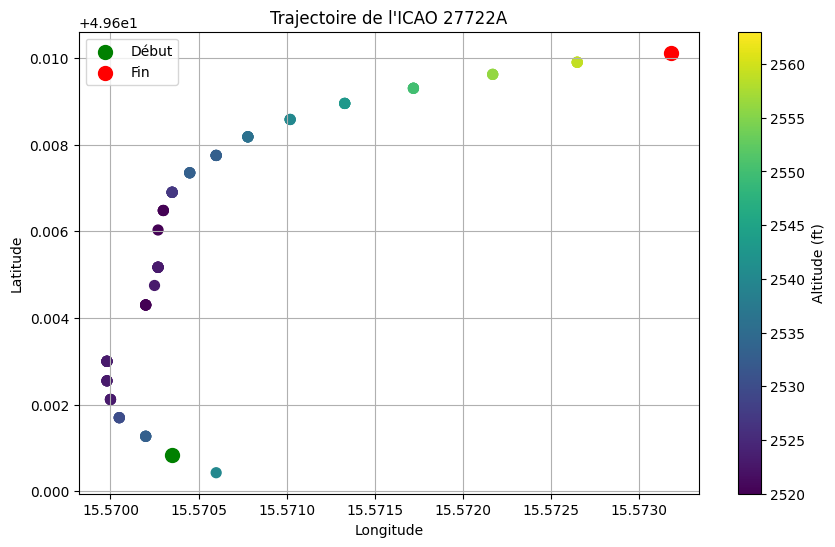

In [12]:
# Supprimer les lignes invalides
df_icao_clean = df_icao.dropna(subset=["altitude", "lat", "lon"])

# Coordonnées et altitude
x = df_icao_clean["lon"]
y = df_icao_clean["lat"]
altitude = df_icao_clean["altitude"]

# Création du scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(x, y, c=altitude, cmap="viridis", s=50)

# Barre de couleur
cbar = plt.colorbar(sc)
cbar.set_label("Altitude (ft)")

# Premier point en vert
plt.scatter(x.iloc[0], y.iloc[0], color="green", s=100, label="Début")

# Dernier point en rouge
plt.scatter(x.iloc[-1], y.iloc[-1], color="red", s=100, label="Fin")

# Texte et légende
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Trajectoire de l'ICAO {icao_choisi}")
plt.legend()
plt.grid(True)

plt.show()


Nous observons un graphe avec en axis la longitude et latitude, les points de couleurs étant l'altitude.

#### 2.4 — Interprétation post‑visualisation

1. La trajectoire semble‑elle linéaire, courbée, chaotique ?

On observe une trajectoire en arc, régulière, sans zigzags : elle est courbée. Elle ne présente aucun comportement chaotique : les points sont bien alignés selon une courbe lisse.

Cela suggère un virage progressif ou une correction de trajectoire.

2. L’avion monte‑t‑il ou descend‑il ?

L'avion a tendance à **monter**. La barre de couleur et la valeur finale montrent : début ≈ 2520 ft / fin ≈ 2562 ft

Donc l'altitude augmente sur la durée (+40 ft environ).
Ce n'est pas une montée forte mais plutôt un palier ascendant léger, cohérent avec une phase de stabilisation ou ajustement.

3. Le cap (heading) évolue‑t‑il de manière cohérente ?

Le cap change progressivement, ce qui correspond à un virage.
Aucune rupture brusque, pas de changement brutal de direction il y a donc heading cohérent.


### Partie 3 : Détection d’anomalies de trajectoire

#### 3.1 - Déviation de cap anormale

In [13]:
def detect_heading_deviation_fast(df, threshold_deg=30, window_s=20):
    df = df.sort_values("timestamp").reset_index(drop=True)

    events = []
    j = 0  # pointeur de fenêtre mobile

    for i in range(len(df)):
        t_i = df.loc[i, "timestamp"]
        h_i = df.loc[i, "heading"]

        # avancer j jusqu’à dépasser +20s
        while j < len(df) and (df.loc[j, "timestamp"] - t_i).total_seconds() <= window_s:
            j += 1

        # j s’est arrêté au premier point >20s, donc comparer seulement i et j-1
        k = j - 1
        if k > i:
            h_k = df.loc[k, "heading"]

            if pd.notna(h_i) and pd.notna(h_k):
                # diff modulo 360
                diff = abs((h_i - h_k + 180) % 360 - 180)

                if diff > threshold_deg:
                    events.append({
                        "index": i,
                        "time": t_i,
                        "deg_change": diff
                    })

    return pd.DataFrame(events)


df_heading_devs = detect_heading_deviation_fast(df_icao)

print(df_heading_devs)
print(f"Nombre d'anomalies détectées : {len(df_heading_devs)}")


    index                    time  deg_change
0       0 2025-11-19 11:19:36.262        56.0
1       1 2025-11-19 11:19:36.304        56.0
2       2 2025-11-19 11:19:36.341        56.0
3       3 2025-11-19 11:19:36.441        56.0
4       4 2025-11-19 11:19:36.478        56.0
..    ...                     ...         ...
65     65 2025-11-19 11:19:53.992        42.0
66     66 2025-11-19 11:19:54.096        35.0
67     67 2025-11-19 11:19:54.177        35.0
68     68 2025-11-19 11:19:54.246        35.0
69     73 2025-11-19 11:19:55.646        49.0

[70 rows x 3 columns]
Nombre d'anomalies détectées : 70


1. L’avion analysé présente-t-il de telles déviations ? 

    L'avion présent des déviations, on en dénombre 69

2. À quel moment ?

    Lors du vol du début à la fin

#### 3.2 - Montée/descente brusque

In [14]:
def detect_vertical_rates(df, up_thresh=2500, down_thresh=-3000):
    df = df.sort_values("timestamp").reset_index(drop=True)
    
    # delta temps (en minutes)
    dt = df["timestamp"].diff().dt.total_seconds() / 60
    
    # variation d’altitude
    dalt = df["altitude"].diff()
    
    df["rate_fpm"] = dalt / dt
    
    # montées rapides
    fast_up = df[df["rate_fpm"] > up_thresh]
    
    # descentes dangereuses
    fast_down = df[df["rate_fpm"] < down_thresh]
    
    return fast_up, fast_down

fast_up, fast_down = detect_vertical_rates(df_icao)

print("Montées rapides:\n", fast_up)
print("Descente dangereuse:\n", fast_down)


Montées rapides:
       icao registration               timestamp       lat       lon  altitude  \
9   27722A      OKYUL41 2025-11-19 11:19:38.055  49.60127  15.57020    2533.0   
15  27722A      OKYUL41 2025-11-19 11:19:39.103  49.60085  15.57035    2536.0   

    velocity  heading      rate_fpm  
9       93.0    346.0   5294.117647  
15      92.0    342.0  11470.588235  
Descente dangereuse:
       icao registration               timestamp       lat       lon  altitude  \
10  27722A      OKYUL41 2025-11-19 11:19:38.056  49.60170  15.57005    2530.0   
16  27722A      OKYUL41 2025-11-19 11:19:39.132  49.60212  15.57000    2523.0   
73  27722A      OKYUL41 2025-11-19 11:19:55.646  49.60735  15.57045    2533.0   

    velocity  heading       rate_fpm  
10      93.0    350.0 -180000.000000  
16      94.0    355.0  -26896.551724  
73      94.0      9.0   -4615.384615  


Nous observons différentes descente ou monté brusque lors du vol de notre avion : 
2 montée rapides et 3 descentes dangereuses.

#### 3.3 - Détection du motif “hippodrome” (boucles)

In [16]:
import pandas as pd
import numpy as np

def detect_hippodrome(df, min_laps=2, max_std_alt=100, max_std_vel=20):
    df = df.copy()

    # Variation d’angle normalisée [-180, 180]
    df["d_heading"] = df["heading"].diff().apply(
        lambda x: abs((x + 180) % 360 - 180) if pd.notna(x) else 0
    )

    # Rotation cumulée
    df["cum_turn"] = df["d_heading"].cumsum()

    # Nombre de tours complets
    df["laps"] = (df["cum_turn"] // 360).clip(lower=0).astype(int)

    # Condition : au moins X tours
    loop_mask = df["laps"] >= min_laps
    if not loop_mask.any():
        return pd.DataFrame()

    df_loops = df[loop_mask]

    # Vérification stabilité
    alt_std = df_loops["altitude"].std()
    vel_std = df_loops["velocity"].std()

    stable_alt = alt_std < max_std_alt
    stable_vel = vel_std < max_std_vel

    if not (stable_alt and stable_vel):
        return pd.DataFrame()

    return df_loops[[
        "icao", "registration", "timestamp",
        "lat", "lon", "altitude", "velocity",
        "heading", "laps"
    ]]


# ================================
#   CALCUL DES LAPS POUR LE LOG
# ================================

df_icao_clean = df_icao_clean.copy()
df_icao_clean["d_heading"] = df_icao_clean["heading"].diff().apply(
    lambda x: abs((x + 180) % 360 - 180) if pd.notna(x) else 0
)
df_icao_clean["cum_turn"] = df_icao_clean["d_heading"].cumsum()
df_icao_clean["laps"] = (df_icao_clean["cum_turn"] // 360).clip(lower=0).astype(int)


# ================================
#   DIAGNOSTIC + AFFICHAGE
# ================================

df_hippo = detect_hippodrome(df_icao_clean)

print("\n====== DIAGNOSTIC HIPPO ======\n")

print("Tours complets détectés (laps max) :", df_icao_clean["laps"].max())

if (df_icao_clean["laps"] >= 1).any():
    df_loops_all = df_icao_clean[df_icao_clean["laps"] >= 1]
    print("Écart-type altitude (pendant les tours) :", df_loops_all["altitude"].std())
    print("Écart-type vitesse  (pendant les tours) :", df_loops_all["velocity"].std())
else:
    print("Aucun début de rotation, pas d'analyse de stabilité.")

print("\nTaille du dataframe hippodrome :", len(df_hippo))

if len(df_hippo) > 0:
    print("\n  Hippodrome détecté !\n")
    print(df_hippo.head())
else:
    print("\n Aucun hippodrome détecté.\n")




====== DIAGNOSTIC HIPPO ======

Tours complets détectés (laps max) : 0
Aucun début de rotation, pas d'analyse de stabilité.

Taille du dataframe hippodrome : 0

 Aucun hippodrome détecté.



#### 3.4 - Zones sensibles

In [20]:
# --- Haversine ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * \
        math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
    return 2 * R * math.asin(math.sqrt(a))


# --- Charge les zones JSON ---
def load_zones(path):
    with open(path, "r") as f:
        return json.load(f)


# --- Test point-in-polygon (ray casting) ---
def point_in_poly(lat, lon, poly):
    inside = False
    n = len(poly)
    p1x, p1y = poly[0]

    for i in range(n + 1):
        p2x, p2y = poly[i % n]
        if min(p1y, p2y) < lon <= max(p1y, p2y):
            if lat <= max(p1x, p2x):
                xinters = (lon - p1y) * (p2x - p1x) / (p2y - p1y + 1e-12) + p1x
                if lat <= xinters:
                    inside = not inside
        p1x, p1y = p2x, p2y

    return inside


# --- Détection zones ---
def detect_zones(df, zones, threshold_km=20):

    alerts = []

    for _, row in df.iterrows():
        lat, lon, icao = row["lat"], row["lon"], row["icao"]

        for z in zones:

            # --- Cas 1 : cercle ---
            if z["type"] == "circle":
                z_lat, z_lon = z["center"]
                d = haversine(lat, lon, z_lat, z_lon)

                if d < threshold_km:
                    alerts.append({
                        "icao": icao,
                        "zone": z["name"],
                        "distance_km": round(d, 2),
                        "timestamp": row["timestamp"]
                    })

            # --- Cas 2 : polygone ---
            elif z["type"] == "polygon":
                if point_in_poly(lat, lon, z["points"]):
                    alerts.append({
                        "icao": icao,
                        "zone": z["name"],
                        "distance_km": 0,
                        "timestamp": row["timestamp"]
                    })

    return pd.DataFrame(alerts)


# --- Utilisation ---
zones = load_zones("zones_sensibles.json")
df_zone_hits = detect_zones(df, zones)

print("\n========== RÉSULTATS ZONES SENSIBLES ==========\n")

if df_zone_hits.empty:
    print("AUCUN avion n'est passé à moins de 20 km d'une zone sensible.\n")
else:
    # 1. Liste unique des avions concernés
    icaos = df_zone_hits["icao"].unique()
    print(f"Nombre d'avions concernés : {len(icaos)}")
    print("ICAO détectés :", ", ".join(icaos), "\n")

    # 2. Liste des zones touchées
    zones_detected = df_zone_hits["zone"].unique()
    print(f"Zones sensibles concernées ({len(zones_detected)}) :")
    for z in zones_detected:
        print(" •", z)
    print()

    # 3. Résumé global
    print("Nombre total d'événements détectés :", len(df_zone_hits), "\n")

    # 4. Exemples détaillés
    print("Exemples d'événements :")
    print(df_zone_hits.head())
    print()



========== RÉSULTATS ZONES SENSIBLES ==========

Nombre d'avions concernés : 2
ICAO détectés : 4A08EA, 392AEC 

Zones sensibles concernées (1) :
 • Zone A

Nombre total d'événements détectés : 26 

Exemples d'événements :
     icao    zone  distance_km               timestamp
0  4A08EA  Zone A        11.41 2025-11-19 11:19:36.184
1  392AEC  Zone A        13.43 2025-11-19 11:19:37.461
2  392AEC  Zone A        13.49 2025-11-19 11:19:38.139
3  4A08EA  Zone A        10.96 2025-11-19 11:19:40.402
4  392AEC  Zone A        13.58 2025-11-19 11:19:40.446



### Partie 4 - Synthèse 

### Partie 5 - Carte interactive Folium

In [71]:
import branca.colormap as cm

# centre la carte
center = [df_icao['lat'].mean(),df_icao['lon'].mean()]
m = folium.Map(location=center, zoom_start=10, tiles='OpenStreetMap')

# colormap
colormap = cm.linear.YlGnBu_09.scale(df_icao['altitude'].min(), df_icao['altitude'].max())
colormap.caption = 'Altitude (ft)'
colormap.add_to(m)

# polyligne colorée par segments (interpolation)
locations = list(zip(df_icao['lat'], df_icao['lon']))
for i in range(len(df_icao)-1):
    seg = [locations[i], locations[i+1]]
    val = float(df_icao.loc[i,'altitude'])
    folium.PolyLine(seg, color=colormap(val), weight=3, opacity=0.8).add_to(m)

# points (optionnel) et clustering anomalies
#mc = MarkerCluster().add_to(m)
#for i, row in df_icao.iterrows():
#    popup = folium.Popup(f"t: {row['timestamp']}<br>alt: {row['altitude']}<br>hdg: {row.get('heading','n/a')}", max_width=250)
#    folium.CircleMarker((row['lat'], row['lon']), radius=3, fill=True, fill_opacity=0.8, popup=popup).add_to(mc)

# heatmap (convert lat/lon to list)
HeatMap(data=df_icao[['lat','lon']].values.tolist(), radius=10).add_to(m)

# marquer anomalies détectées (heading devs + vertical rates)
for _, r in df_heading_devs.iterrows():
    i = int(r['index'])
    folium.CircleMarker((df_icao.loc[i,'lat'], df_icao.loc[i,'lon']), radius=7, color='orange', fill=True, fill_color='orange', popup=f"Hdg dev {r['deg_change']:.1f}°").add_to(m)
for _, r in fast_up.iterrows():
    folium.CircleMarker((r['lat'], r['lon']), radius=7, color='green', fill=True, popup=f"Up {r['rate_fpm']:.1f} fpm").add_to(m)
for _, r in fast_down.iterrows():
    folium.CircleMarker((r['lat'], r['lon']), radius=7, color='red', fill=True, popup=f"Down {r['rate_fpm']:.1f} fpm").add_to(m)

m.save('trajectoire_anomalies.html')
print("Carte sauvegardée: trajectoire_anomalies.html")


Carte sauvegardée: trajectoire_anomalies.html
